In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd

# Set the file path of the CSV file in your Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/San_Marcos.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Print the first five rows of the DataFrame
print(df.head())



Mounted at /content/drive
        Date  Discharge
0  5/26/1956       65.0
1  5/27/1956       69.0
2  5/28/1956       69.0
3  5/29/1956       68.0
4  5/30/1956       65.0


In [2]:
df.head()

,Date,Discharge
0,5/26/1956,65.0
1,5/27/1956,69.0
2,5/28/1956,69.0
3,5/29/1956,68.0
4,5/30/1956,65.0


In [3]:
# Check for null values in the "Discharge" column
null_count = df['Discharge'].isnull().sum()

# Print the number of null values in the "Discharge" column
print(f"The 'Discharge' column has {null_count} null values.")

The 'Discharge' column has 2 null values.


In [4]:
# Fill missing values in the "Discharge" column using linear interpolation
df['Filled_values'] = df['Discharge'].interpolate()

In [5]:
df.head()

,Date,Discharge,Filled_values
0,5/26/1956,65.0,65.0
1,5/27/1956,69.0,69.0
2,5/28/1956,69.0,69.0
3,5/29/1956,68.0,68.0
4,5/30/1956,65.0,65.0


In [6]:
df = df.drop('Discharge', axis=1)

In [7]:
df = df.rename(columns={'Filled_values': 'Discharge'})

In [8]:
# split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size, :]
test_data = df.iloc[train_size:, :]

In [9]:
df.head()

,Date,Discharge
0,5/26/1956,65.0
1,5/27/1956,69.0
2,5/28/1956,69.0
3,5/29/1956,68.0
4,5/30/1956,65.0


In [10]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data['Discharge'].values.reshape(-1,1))


In [11]:
# create sequences of data for LSTM
X_train = []
y_train = []
lookback = 10  # number of time steps to look back
for i in range(lookback, train_size):
    X_train.append(train_data_scaled[i-lookback:i, 0])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
# build LSTM model with dropout layers
!pip install --upgrade tensorflow keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=16, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# add early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# fit the model with early stopping and learning rate reduction on plateau
history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=False, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
489/489 [==============================] - 18s 16ms/step - loss: 0.0802 - val_loss: 0.0043 - lr: 0.0010
Epoch 2/100
489/489 [==============================] - 8s 17ms/step - loss: 0.0058 - val_loss: 0.0057 - lr: 0.0010
Epoch 3/100
489/489 [==============================] - 7s 14ms/step - loss: 0.0049 - val_loss: 0.0113 - lr: 0.0010
Epoch 4/100
489/489 [==============================] - 8s 17ms/step - loss: 0.0043 - val_loss: 0.0079 - lr: 0.0010
Epoch 5/100
489/489 [==============================] - 7s 15ms/step - loss: 0.0038 - val_loss: 0.0062 - lr: 0.0010
Epoch 6/100
489/489 [==============================] - ETA: 0s - loss: 0.0033
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
489/489 [==============================] - 8s 17ms/step - loss: 0.0033 - val_loss: 0.0052 - lr: 0.0010
Epoch 7/100
489/489 [==============================] - 7s 14ms/step - loss: 0.0027 - val_loss: 0.0018 - lr: 2.0000e-04
Epoch 8/100
489/489 [==========================

In [16]:
# get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

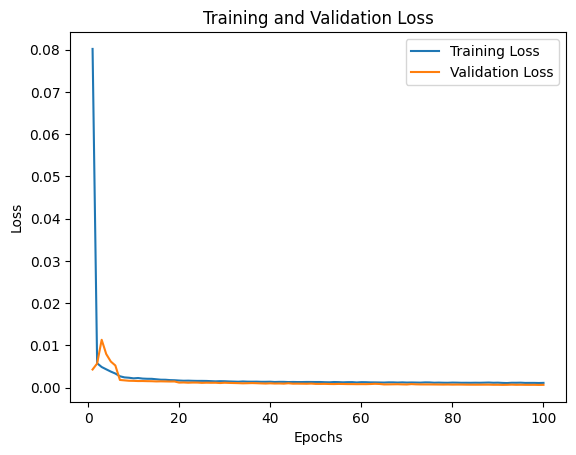

In [17]:
# plot training and validation loss over epochs
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# prepare the test data
inputs = df['Discharge'][len(df) - len(test_data) - lookback:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)


In [19]:
# create test sequences
X_test = []
for i in range(lookback, len(test_data)+lookback):
    X_test.append(inputs[i-lookback:i,0])
X_test = np.array(X_test)

In [20]:
# reshape test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predict the test data
predicted_data_scaled = model.predict(X_test)

predicted_data = scaler.inverse_transform(predicted_data_scaled)


153/153 [==============================] - 2s 7ms/step


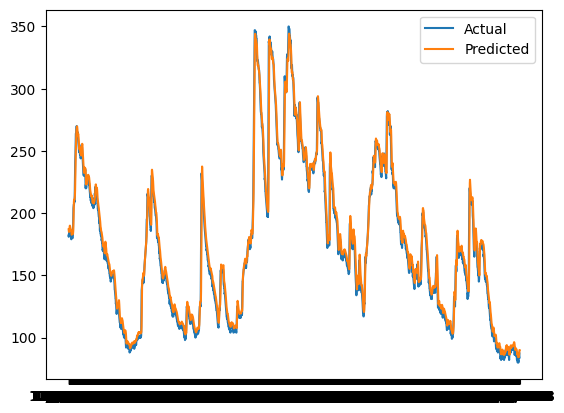

In [21]:
# plot the predicted values against the actual values
import matplotlib.pyplot as plt
plt.plot(test_data['Date'], test_data['Discharge'], label='Actual')
plt.plot(test_data['Date'], predicted_data, label='Predicted')
plt.legend()
plt.show()

In [22]:
import plotly.graph_objects as go



# create plotly figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data['Date'], y=test_data['Discharge'], name='Actual'))
fig.add_trace(go.Scatter(x=test_data['Date'], y=predicted_data.flatten(), name='Predicted'))
fig.update_layout(title='Discharge Prediction', xaxis_title='Date', yaxis_title='Discharge')
fig.show()


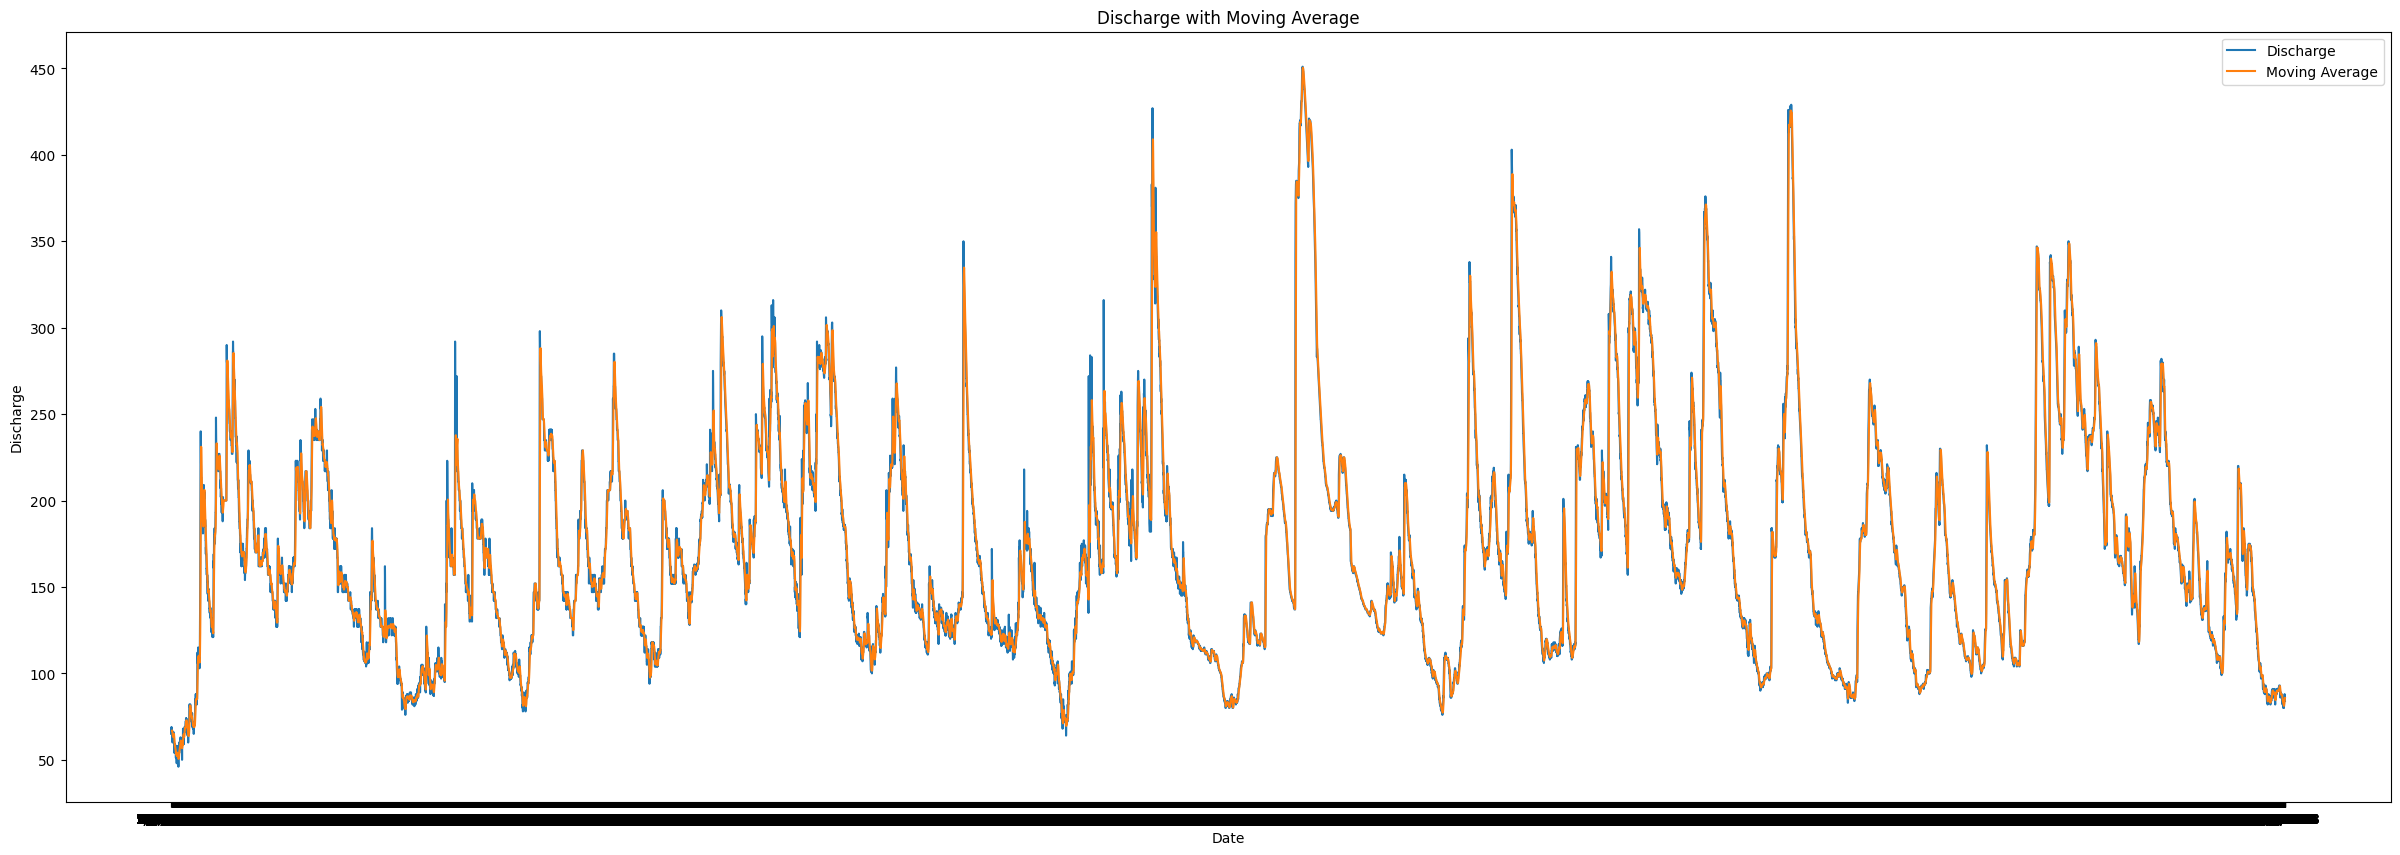

In [23]:
import matplotlib.pyplot as plt

# calculate rolling mean with window of 10
rolling_mean = df['Discharge'].rolling(window=10).mean()

# plot original data and rolling mean
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(df['Date'], df['Discharge'], label='Discharge')
ax.plot(df['Date'], rolling_mean, label='Moving Average')
ax.set(title='Discharge with Moving Average', xlabel='Date', ylabel='Discharge')
ax.legend()

plt.show()


In [24]:
import plotly.graph_objects as go

# create plotly figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data['Date'], y=train_data['Discharge'], name='Historical Discharge'))
fig.add_trace(go.Scatter(x=test_data['Date'], y=test_data['Discharge'], name='Actual Discharge'))
fig.add_trace(go.Scatter(x=test_data['Date'], y=predicted_data.flatten(), name='Predicted Discharge'))
